Text(0.5, 1.0, 'Mesostructure. Orange: JTFS. Green: SCRAPL')

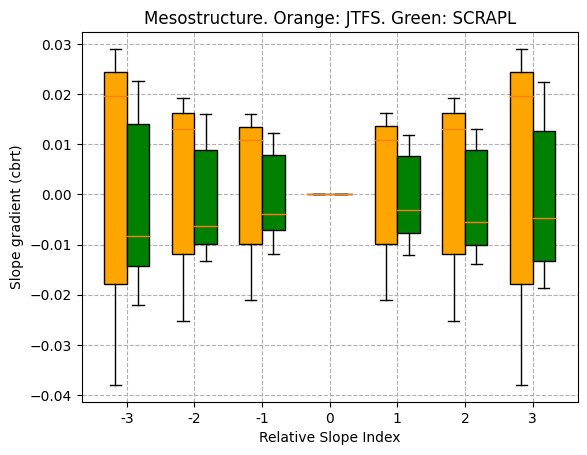

In [55]:
from matplotlib import pyplot as plt
import numpy as np
import os
import torch

def load_jacobian(density_idx, slope_idx, seed, data_dir):
    filepath = f"jacobian_density-{density_idx}_slope-{slope_idx}_seed-{seed}.pt"
    jac_path = os.path.join(data_dir, "jacobians_7x7", filepath)
    return torch.load(jac_path).double()[1:, :]

def load_jtfs(density_idx, slope_idx, seed, data_dir):
    filepath = f"jtfs_density-{density_idx}_slope-{slope_idx}_seed-{seed}.pt"
    jtfs_path = os.path.join(data_dir, "jtfs_7x7", filepath)
    return torch.load(jtfs_path).double()[1:, 0]

data_dir = "icassp2024_scrapl_data"

H_jtfs = []
H_scrapl = []
common_density_idx = 3
y_slope_idx = 4

SY = []
for seed in range(10):
    y_coords = (common_density_idx, y_slope_idx)
    Sy = load_jtfs(*y_coords, seed=seed, data_dir=data_dir)
    SY.append(Sy)
SY = torch.stack(SY)
Sy = torch.mean(SY, dim=0)

for x_slope_idx in range(7):

    SX, JX = [], []
    for seed in range(10):
        x_coords = (common_density_idx, x_slope_idx)
        Sx = load_jtfs(*x_coords, seed=seed, data_dir=data_dir)
        Jx = load_jacobian(*x_coords, seed=seed, data_dir=data_dir)
        SX.append(Sx)
        JX.append(Jx)
    SX = torch.stack(SX, dim=0)
    JX = torch.stack(JX, dim=0)

    G_scrapl = []
    for _ in range(100):
        Sx_scrapl, Sy_scrapl, Jx_scrapl = [], [], []
        for path in range(SX.shape[-1]):
            random_seed = torch.randint(SX.shape[0], (1,))
            Jx_scrapl.append(JX[random_seed, path, :].squeeze())
            Sx_scrapl.append(SX[random_seed, path].squeeze())
        Jx_scrapl = torch.stack(Jx_scrapl, dim=0)
        Sx_scrapl = torch.stack(Sx_scrapl, dim=0)
        g_scrapl = Jx_scrapl.T @ (Sy - Sx_scrapl)
        G_scrapl.append(g_scrapl)
    G_scrapl = torch.stack(G_scrapl, dim=0).squeeze()

    G_jtfs = []
    for seed in range(SX.shape[0]):
        g_jtfs = JX[seed, :, :].T @ (Sy - SX[seed, :])
        G_jtfs.append(g_jtfs)
    G_jtfs = torch.stack(G_jtfs, dim=0).squeeze()

    # Take gradient with respect to coordinate 1 (slope)
    H_jtfs.append(G_jtfs[:, 1].detach())
    H_scrapl.append(G_scrapl[:, 1].detach())

H_jtfs = torch.stack(H_jtfs)
H_scrapl = torch.stack(H_scrapl)

positions = np.arange(-3, 4)
plt.boxplot(np.cbrt(H_jtfs), positions=positions-1/6, widths=1/3,
    patch_artist=True, boxprops=dict(facecolor='orange'));
plt.boxplot(np.cbrt(H_scrapl), positions=positions+1/6,widths=1/3,
    patch_artist=True, boxprops=dict(facecolor='green'));

plt.gca().set_xticks(positions)
plt.gca().set_xticklabels(positions)
plt.grid(linestyle='--')
plt.xlabel("Relative Slope Index")
plt.ylabel("Slope gradient (cbrt)")
# Mesostructure means that the target has seed=0
# whereas predictions have seed>0 between 1 and 9
plt.title("Mesostructure. Orange: JTFS. Green: SCRAPL")

Text(0.5, 1.0, 'Mesostructure. Orange: JTFS. Green: SCRAPL')

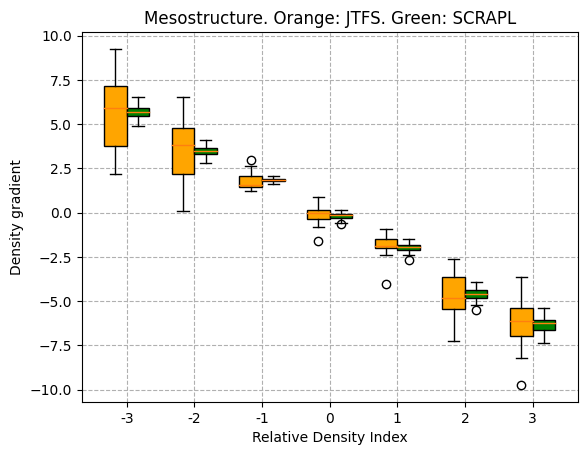

In [61]:
data_dir = "icassp2024_scrapl_data"

H_jtfs = []
H_scrapl = []
common_slope_idx = 3
y_density_idx = 3

SY = []
for seed in range(10):
    y_coords = (y_density_idx, common_slope_idx)
    Sy = load_jtfs(*y_coords, seed=seed, data_dir=data_dir)
    SY.append(Sy)
SY = torch.stack(SY)
Sy = torch.mean(SY, dim=0)

for x_density_idx in range(7):

    SX, JX = [], []
    for seed in range(10):
        x_coords = (x_density_idx, common_slope_idx)
        Sx = load_jtfs(*x_coords, seed=seed, data_dir=data_dir)
        Jx = load_jacobian(*x_coords, seed=seed, data_dir=data_dir)
        SX.append(Sx)
        JX.append(Jx)
    SX = torch.stack(SX, dim=0)
    JX = torch.stack(JX, dim=0)

    G_scrapl = []
    for _ in range(100):
        Sx_scrapl, Sy_scrapl, Jx_scrapl = [], [], []
        for path in range(SX.shape[-1]):
            random_seed = torch.randint(SX.shape[0], (1,))
            Jx_scrapl.append(JX[random_seed, path, :].squeeze())
            Sx_scrapl.append(SX[random_seed, path].squeeze())
        Jx_scrapl = torch.stack(Jx_scrapl, dim=0)
        Sx_scrapl = torch.stack(Sx_scrapl, dim=0)
        g_scrapl = Jx_scrapl.T @ (Sy - Sx_scrapl)
        G_scrapl.append(g_scrapl)
    G_scrapl = torch.stack(G_scrapl, dim=0).squeeze()

    G_jtfs = []
    for seed in range(SX.shape[0]):
        g_jtfs = JX[seed, :, :].T @ (Sy - SX[seed, :])
        G_jtfs.append(g_jtfs)
    G_jtfs = torch.stack(G_jtfs, dim=0).squeeze()

    # Take gradient with respect to coordinate 0 (density)
    H_jtfs.append(G_jtfs[:, 0].detach())
    H_scrapl.append(G_scrapl[:, 0].detach())

H_jtfs = torch.stack(H_jtfs)
H_scrapl = torch.stack(H_scrapl)

positions = np.arange(-3, 4)
plt.boxplot(H_jtfs, positions=positions-1/6, widths=1/3,
    patch_artist=True, boxprops=dict(facecolor='orange'));
plt.boxplot(H_scrapl, positions=positions+1/6,widths=1/3,
    patch_artist=True, boxprops=dict(facecolor='green'));

plt.gca().set_xticks(positions)
plt.gca().set_xticklabels(positions)
plt.grid(linestyle='--')
plt.xlabel("Relative Density Index")
plt.ylabel("Density gradient")
# Mesostructure means that the target has seed=0
# whereas predictions have seed>0 between 1 and 9
plt.title("Mesostructure. Orange: JTFS. Green: SCRAPL")